<a href="https://colab.research.google.com/github/dkp3012/assignment/blob/main/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6: Implement clustering methods in your dataset.

##Clustering data using scikit-learn

Clustering algorithms allow you to automatically find ways to group multidimentional data into clusters.


The following algorithms are demonstrated in this notebook:

* k-means
* Mean shift
* DBSCAN
* Agglomerative clustering





## Install python modules


In [39]:
!pip install --user plotly==4.1.1

## Imports

Import the python modules that we need in the rest of the notebook.

In [40]:
%matplotlib inline
from time import sleep
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.animation
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import lines
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

## Load the customer and trading activity data

Use the cell below to load the merged_customers.csv file into a pandas DataFrame.

In [41]:
df = pd.read_csv("mergedcustomers.csv")

## Prepare the customer data




In [42]:
# Save the CHURNRISK label column for later.
known_risk = df['CHURNRISK']

# Combine gains - losses into a profit column,
# and select a some of the numeric trader data to use for our customer clustering example.
keep_columns = ['AGE', 'TOTALUNITSTRADED', 'DAYSSINCELASTTRADE', 'DAYSSINCELASTLOGIN', 'PROFIT_YTD']

df_churn = df.assign(PROFIT_YTD=df.apply(lambda row: row.NETREALIZEDGAINS_YTD - row.NETREALIZEDLOSSES_YTD, axis=1).values)[keep_columns]

# Pick 3 features to use later in 3D charts
x_name = 'AGE'
y_name = 'PROFIT_YTD'
z_name = 'DAYSSINCELASTTRADE'

df_churn.head()

,AGE,TOTALUNITSTRADED,DAYSSINCELASTTRADE,DAYSSINCELASTLOGIN,PROFIT_YTD
0,47,58,13,2,-152.76525
1,25,13,10,4,1349.63500
2,42,28,5,4,1123.61250
3,52,36,6,3,-652.56550
4,40,8,9,4,-1496.14950


## Prepare the scikit-learn datasets



In [43]:
# Generate 10 features even though we generally only chart 3 (these are nice multidemensional, spherical clusters)
n_features = 10
n_samples = 1000
random_state = 100

# blobs is our generated data set.  blob_labels is the expected blob cluster membership.
blobs, blob_labels = make_blobs(n_samples=n_samples, n_features=n_features, random_state=random_state)

# Put the data set in a DataFrame and give it some columns names.
blobs_df = pd.DataFrame(blobs, columns=['X', 'Y', 'Z', 'A', 'B', 'C', 'D', 'E', 'F', 'G'])
blobs_df['CLUSTER'] = blob_labels

# 2-dimensional moons dataset to show where some algorithms excel.
moons, moon_labels = make_moons(n_samples=n_samples, noise=.05)

## Setup visualization


In [44]:
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = [8, 3]

Define some functions that will be used repeatedly for visualization.

In [45]:
# 3D matplotlib (plus seaborn) charting with some data prep and optional center points
def show_scatter_3d(df, x_name, y_name, z_name, predicted=None, centers=None,
                    marker='o', cmap=None, edgecolors=None, alpha=0.3,
                    elev=25, azim=10, show_colorbar=True,
                    xlim3d=None, ylim3d=None, zlim3d=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x_index = df.columns.get_loc(x_name)
    y_index = df.columns.get_loc(y_name)
    z_index = df.columns.get_loc(z_name)

    x = df[x_name]
    y = df[y_name]
    z = df[z_name]

    if centers is not None:
        spot_size=15  # Smaller spots make X more visible
        for center in centers:
            if center is not None:
                ax.scatter(center[x_index], center[y_index], center[z_index], marker="X", s=500, color='red')
    else:
        spot_size=30

    # Pass in cmap if necessary, else get a right-sized list here
    if not cmap:
        cmap = ListedColormap(sns.color_palette("Set2",len(set(predicted))))

    chart = ax.scatter(x, y, z, c=predicted, marker=marker, edgecolors=edgecolors, cmap=cmap, s=spot_size, alpha=alpha)

    # Add axis labels
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)

    # Optionally, set the axis limits:
    if xlim3d:
        ax.set_xlim3d(xlim3d)
    if ylim3d:
        ax.set_ylim3d(ylim3d)
    if zlim3d:
        ax.set_zlim3d(zlim3d)

    # Make room for axis titles
    plt.subplots_adjust(bottom=1, top=3, left=0, right=2)

    # Chart rotation
    ax.view_init(elev, azim)

    if show_colorbar:
        fig.colorbar(chart, ticks=list(set(predicted)))

    return fig, ax

In [46]:
RdYlBu = plt.get_cmap('RdYlBu')  # colormap for moons

def show_scatter_moons(data, prediction, centers=[]):
    plt.scatter(data[:, 0], data[:, 1], c=prediction, cmap=RdYlBu, alpha=0.5);
    for center in centers:
        plt.scatter(center[0], center[1], marker="X", s=300, color='red')

In [47]:
# Plotly 3D scatter chart is almost a one-liner, but use this function to keep the params in one place
def plotly_scatter_3d(df, x, y, z, color=None):
    fig = px.scatter_3d(df, x=x, y=y, z=z, color=color,
                    opacity=0.2, template='plotly_dark', color_continuous_scale=px.colors.qualitative.Set1)
    fig.show()

In [48]:
# Use a stacked bar chart for an external evaluation of the churn cluster vs known churn risk

# Map the risk values to sortables (and still OK for the legend)
risk_map = {'High': '2: High', 'Medium': '1: Medium', 'Low': '0: Low'}

# Reusable chart to see if our clusters might help with churn risk prediction
def show_risk_by_cluster(data, risk):

    # Create DataFrame with predicted CLUSTER ID
    data_df = pd.DataFrame(data=data, columns=['CLUSTER'])

    # Add CHURN_RISK using sortable values
    data_df['CHURN_RISK'] = risk.map(risk_map)

    # Group by and count to get count of Hi/Med/Low in each cluster
    grouped_data = data_df.groupby(['CLUSTER', 'CHURN_RISK']).size().to_frame().reset_index()

    # Pivot for charting
    pivot = grouped_data.pivot(index='CLUSTER', columns='CHURN_RISK', values=0).fillna(0)

    # Sort to show descending High and then ascending Low counts
    pivot = pivot.reindex(pivot.sort_values(by=['2: High', '0: Low'], ascending=[False, True]).index)

    # Plot the sorted stacked bar chart
    pivot.plot(kind='bar', stacked=True, color='gbr')

    # Put the legend on the side
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Visualize the input data sets


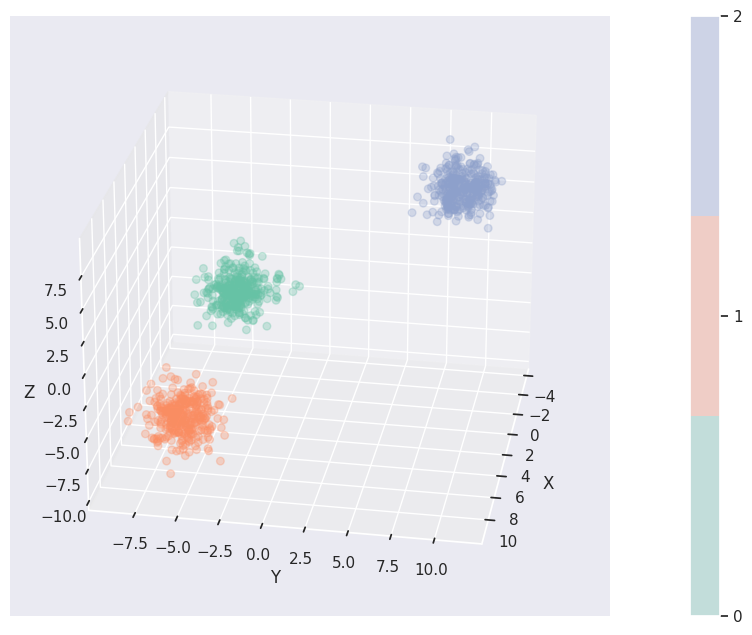

In [49]:
show_scatter_3d(blobs_df, 'X', 'Y', 'Z', predicted=blob_labels);

In [50]:
# This is the same thing we just showed with matplotlib, but now we have tooltips and we can zoom and rotate.
# Rotating the chart can be very helpful when clusters are overlapping in 3-dimensional space.
plotly_scatter_3d(blobs_df, 'X', 'Y', 'Z', color='CLUSTER')

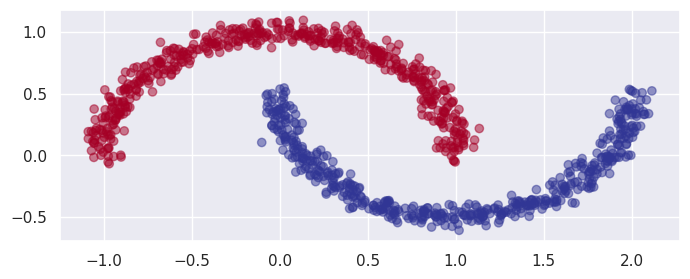

In [51]:
# The moons data set is only two-dimensional but demonstrates some cluster algorithm differences.

show_scatter_moons(moons, moon_labels)

<ipython-input-45-2429d96a9ef3>:29: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



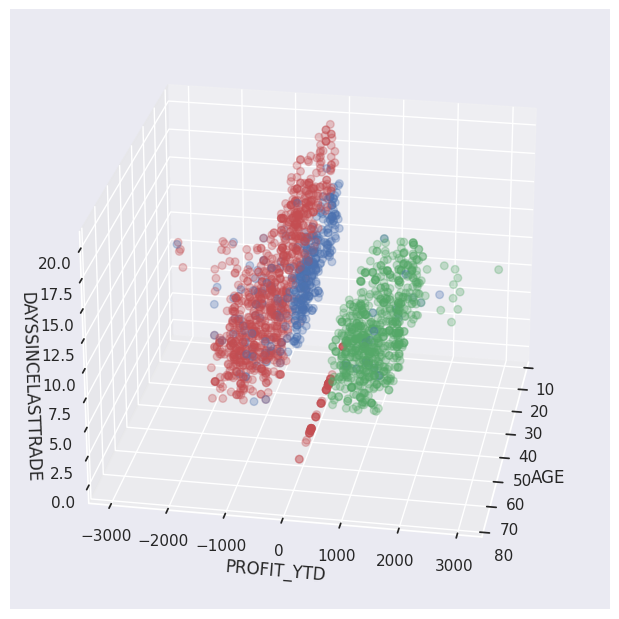

In [52]:
# We did not use k-means yet, let's just use the labels for color
label_colors = known_risk.map({'High': 'r', 'Medium': 'b', 'Low': 'g'})

show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=label_colors, show_colorbar=False);



##k-means

First, we look at k-means clustering.

* For k-means, you have to specify the number of clusters you want. We'll start with 3, but you can run this cell with different values to see what you get.
* We'll add a red `x` to show centriods, when we can.

### k-means with generated hyperspheres

Although we used 10 dimensions and only show 3, the generated hyperspheres are easy for the k-means algorithm to cluster as expected if you pick the correct number for clusters.  If you change `n_clusters`, you'll see that the clusters are combined or split in ways that might not make sense visually.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



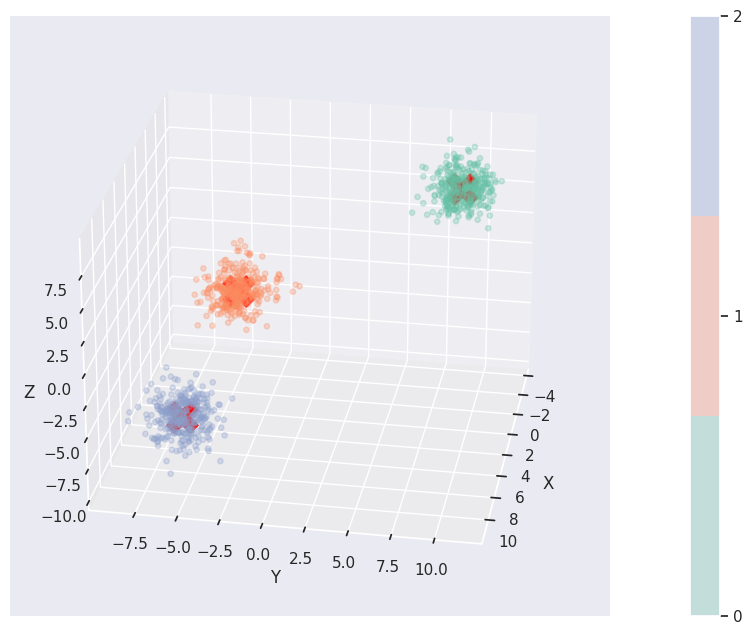

In [53]:
k = 3
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(blobs)
centers = kmeans.cluster_centers_

show_scatter_3d(blobs_df, 'X', 'Y', 'Z', predicted=y_pred, centers=centers);

### k-means with generated moons

The moons data, demonstrates a weakness of k-means. k-means does not recognize the dense crescent shapes which are easy to detect visually. k-means is limited to circles/spheres/hyperspheres. We choose n_clusters=2, but the result is probably not the best for this data set.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



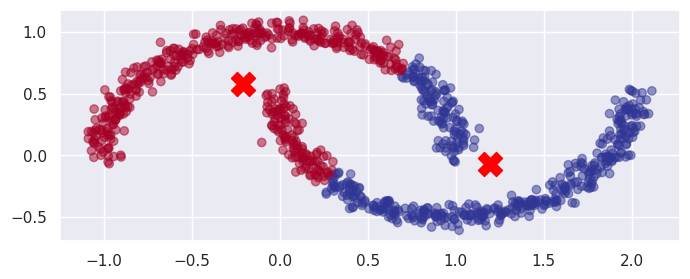

In [54]:
k = 2
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(moons)
centers = kmeans.cluster_centers_

show_scatter_moons(moons, y_pred, centers)

### k-means clustering with our customer data




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



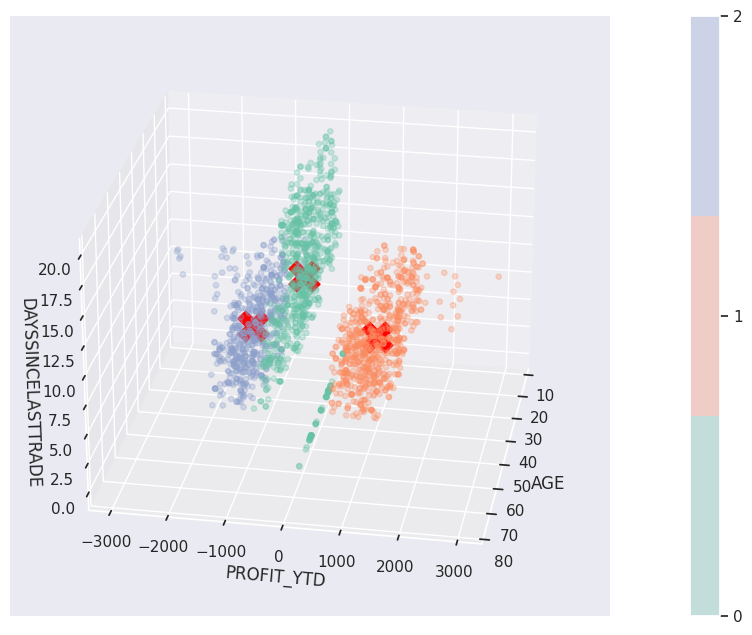

In [55]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
predicted = kmeans.fit_predict(df_churn.values)
centers = kmeans.cluster_centers_

show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=predicted, centers=centers);

### External evaluation



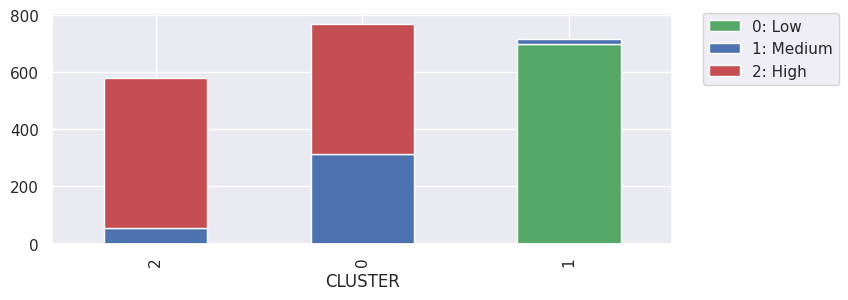

In [56]:
show_risk_by_cluster(predicted, known_risk)

#### Using Plotly


In [57]:
X_df = df_churn.copy()
X_df['CLUSTER'] = predicted
plotly_scatter_3d(X_df, x_name, y_name, z_name, color='CLUSTER')

## Mean shift

Mean shift is centroid-based like k-means, but has some advantages:

1. You don't need to specify n_clusters
2. It is not limited to hyperspheres
3. It recognizes density when seeking cluster centers
4. `cluster_all=False` allows orphans


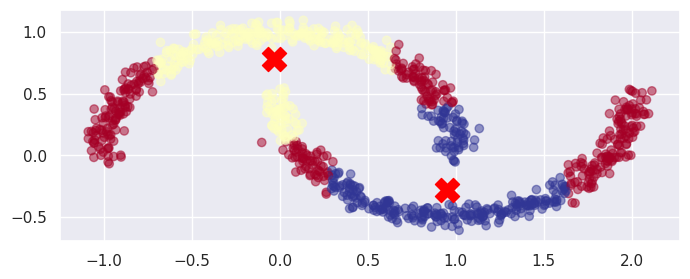

In [58]:
bandwidth = estimate_bandwidth(moons, quantile=.2, n_samples=1000)
ms = MeanShift(cluster_all=False, bandwidth=bandwidth)
y_pred = ms.fit_predict(moons)
centers = ms.cluster_centers_

show_scatter_moons(moons, y_pred, centers)

In [59]:
ms = MeanShift(cluster_all=False)
predicted = ms.fit_predict(df_churn.values)
labels = ms.labels_
centers = ms.cluster_centers_

print("Number of clusters: ", len(centers))

Number of clusters:  5


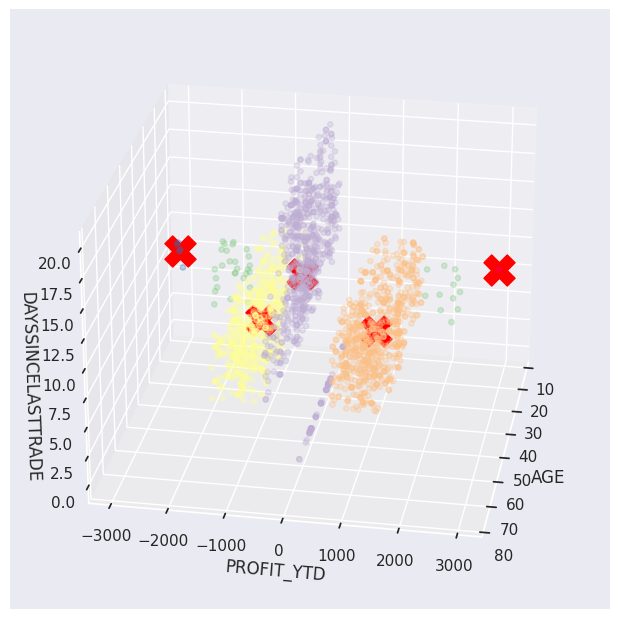

In [60]:
show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=predicted, centers=centers,
                show_colorbar=False,
                cmap=ListedColormap(cm.Accent.colors[:6]));

In [61]:
temp_df = df_churn.copy()
temp_df['CLUSTER'] = predicted
no_outliers_df = temp_df[temp_df['CLUSTER']!=-1]
outliers_df = temp_df[temp_df['CLUSTER']==-1]

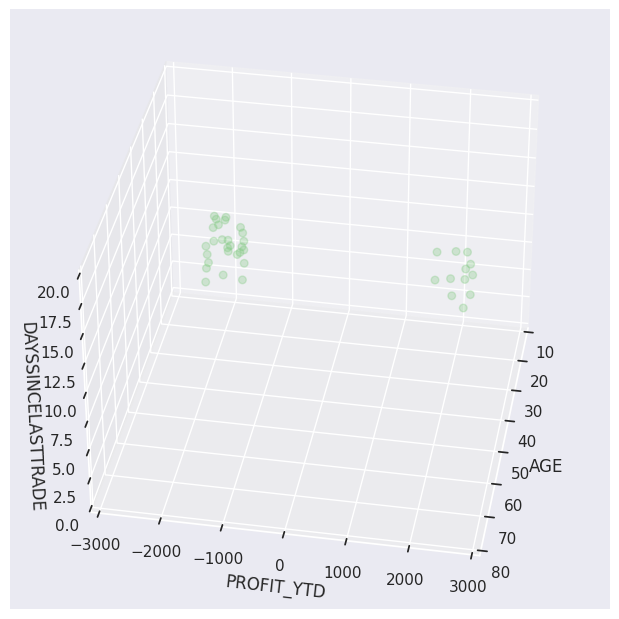

In [62]:
charts = [
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:1])},
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:1])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:1])}
]

# n loops for more time to watch charts
loops = 2
for loop in range(loops):
  for chart in charts:
    clear_output(wait=True)
    fig, ax = show_scatter_3d(chart['dataframe'], x_name, y_name, z_name, predicted=chart['dataframe']['CLUSTER'],
                centers=chart['centers'],
                show_colorbar=False, cmap=chart['cmap'],
                elev=35, azim=10,
                xlim3d=(10, 80), ylim3d=(-3000, 3000), zlim3d=(0, 20))

    display(fig)
    plt.close(fig)
    sleep(1)

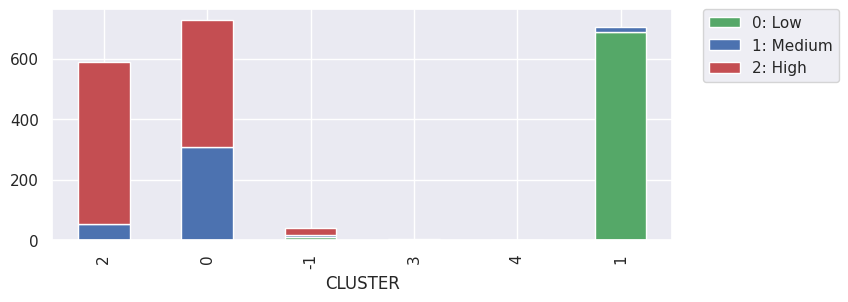

In [63]:
show_risk_by_cluster(predicted, known_risk)

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

Unlike mean shift, DBSCAN understands the concept of outliers. It will not create mini-clusters of outliers, but instead will take all the outliers and put them in cluster -1. These outliers are sometimes called "noise".

In addition, since DBSCAN is density-based and not centroid-based, it is able to predict cluster shapes that k-means and mean shift cannot predict.




In [64]:
from sklearn.cluster import DBSCAN
predicted = DBSCAN(eps=110).fit_predict(df_churn)

print('Number of clusters:', len(set(predicted)) - (1 if -1 in predicted else 0))
print('Number of outliers:', list(predicted).count(-1))

Number of clusters: 6
Number of outliers: 23


In [65]:
temp_df = df_churn.copy()
temp_df['CLUSTER'] = predicted
temp_df['KNOWN_RISK'] = known_risk
temp_df.columns = [str(x) for x in temp_df.columns.values]
no_outliers_df = temp_df[temp_df['CLUSTER']!=-1]
outliers_df = temp_df[temp_df['CLUSTER']==-1]

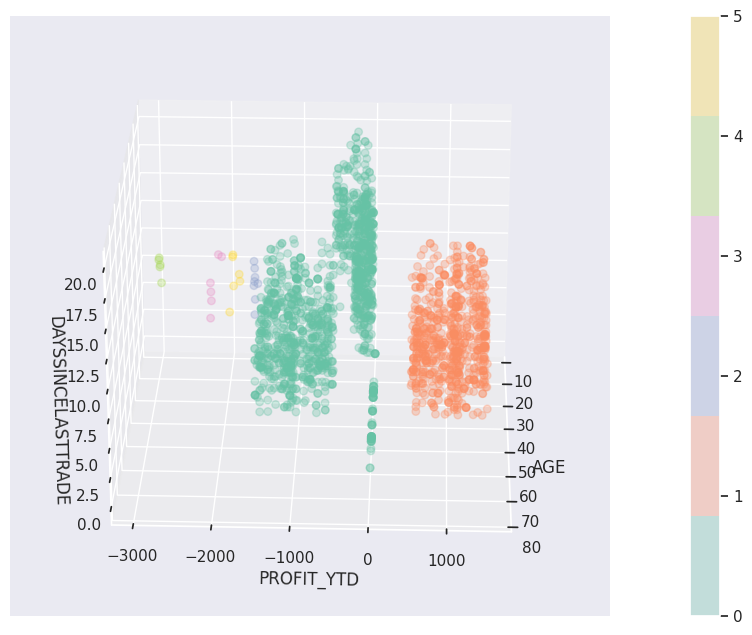

In [66]:
show_scatter_3d(no_outliers_df, x_name, y_name, z_name, predicted=no_outliers_df['CLUSTER'], azim=2);

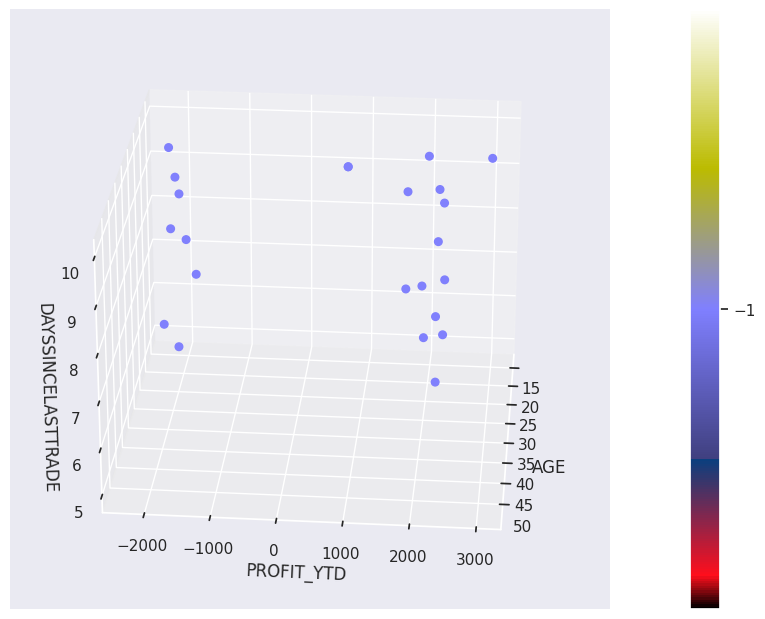

In [67]:
show_scatter_3d(outliers_df, x_name, y_name, z_name, predicted=outliers_df['CLUSTER'], cmap=cm.gist_stern, alpha=1, azim=5);

### DBSCAN with generated moons

The moons data clearly demonstrates how density-based clustering can predict group "shapes" that centroid-based clustering cannot.


Number of clusters: 2
Number of outliers: 1


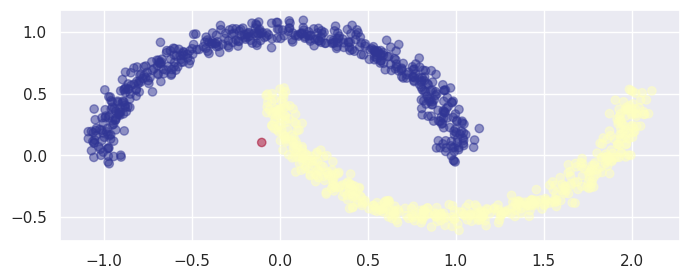

In [68]:
predicted = DBSCAN(eps=.1).fit_predict(moons)

print('Number of clusters:', len(set(predicted)) - (1 if -1 in predicted else 0))
print('Number of outliers:', list(predicted).count(-1))

show_scatter_moons(moons, predicted)

## Hierarchical


In [69]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=500,
                             affinity='euclidean', linkage='complete')
predicted = ac.fit_predict(df_churn.values)

print('Number of clusters:', len(set(predicted)))

Number of clusters: 14


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



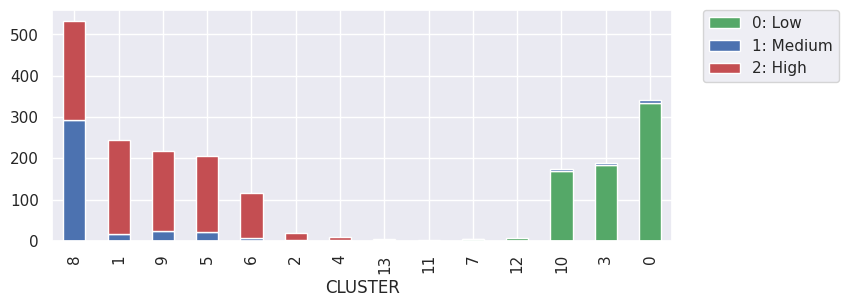

In [70]:
show_risk_by_cluster(predicted, known_risk)

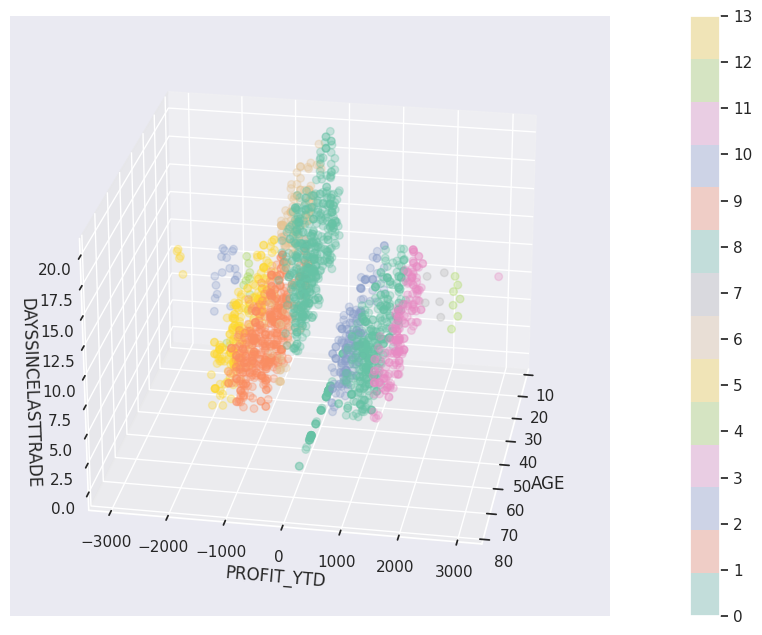

In [71]:
show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=predicted);

In [72]:
X_df = df_churn.copy()
X_df['CLUSTER'] = predicted
plotly_scatter_3d(X_df, x_name, y_name, z_name, color='CLUSTER')